# Compare Twitter and Reddit Populations

This script evaluates how similar subsets of Twitter and Reddit populations are within platform and across platform.
The populations we test are:
- Random US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
- Politically engaged US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
    - Must follow at least 5 politicians
- IRA Twitter accounts identified by Twitter
- Random Reddit accounts  active in 2015-2018
    - Must have posted/commented >= 100 times in this time frame
- Politically engaged Redditors  active in 2015-2018
    - Must have posted/commented >= 100 times in subreddits /r/politics identifies as US-political in this time frame
- IRA Reddit accounts identified by Reddit

In [2]:
%matplotlib inline

In [3]:
import json
import time
import string
import datetime
import matplotlib

import scipy.stats

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [4]:
import sklearn.preprocessing
import sklearn.metrics

In [32]:
from utils.youtube import strip_video_id_from_url

In [147]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%a %b %d %H:%M:%S +0000 %Y")

def convert_time(timestamp):
    created_time = timestamp
    if ( isinstance(created_time, str) ):
        created_time = int(created_time)
        
    d = datetime.datetime.utcfromtimestamp(created_time)
    return d

def get_top_tlds(links_df, user_id_field, top_n=100):
    tld_user_counts = {}
    for tld, group in links_df.groupby("tld"):
        local_users = set(group[user_id_field])
        tld_user_counts[tld] = len(local_users)

    return sorted(tld_user_counts, key=tld_user_counts.get, reverse=True)[:top_n]

def links_df_to_shares(links_df, domains, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_tld_counts = dict(user_posts["tld"].value_counts().items())
        local_vector = [local_tld_counts.get(x, 0) for x in domains]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + domains)

def get_top_channels(yt_df, user_id_field, top_n=100):
    channel_user_counts = {}
    for channel, group in yt_df.groupby("channel_id"):
        local_users = set(group[user_id_field])
        channel_user_counts[channel] = len(local_users)

    return sorted(channel_user_counts, key=channel_user_counts.get, reverse=True)[:top_n]

def channels_df_to_shares(links_df, channels, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_chan_counts = dict(user_posts["channel_id"].value_counts().items())
        local_vector = [local_chan_counts.get(x, 0) for x in channels]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + channels)

In [6]:
top_n_domains = 150
top_n_channels = 500
bootstrap_count = 5000

In [7]:
short_domain_map = {
    "abcn.ws": "abcnews.go.com",
    "amzn.to": "amazon.com",
    "apne.ws": "apnews.com",
    "apple.co": "apple.com",
    "bbc.in": "bbc.com",
    "ble.ac": "bleacherreport.com",
    "bloom.bg": "bloomberg.com",
    "bzfd.it": "buzzfeed.com",
    "cbsloc.al": "cbslocal.com",
    "cnb.cx": "cnbc.com",
    "cnn.it": "cnn.com",
    "cnn.it": "cnn.com",
    "dailym.ai" : "dailymail.co.uk",
    "econ.st": "economist.com",
    "es.pn": "espn.com",
    "fxn.ws": "foxnews.com",
    "hill.cm": "thehill.com",
    "huff.to" : "huffingtonpost.com",
    "lat.ms": "latimes.com",
    "lnkd.in": "linkedin.com",
    "n.pr": "npr.org",
    "nbcnews.to": "nbcnews.com",
    "nydn.us": "nydailynews.com",
    "nyp.st": "nypost.com",
    "nyti.ms": "nytimes.com",
    "on.rt.com": "rt.com",
    "on.wsj.com": "wsj.com",
    "politi.co": "politico.com",
    "redd.it": "reddit.com",
    "reut.rs": "reuters.com",
    "thebea.st": "thedailybeast.com",
    "ti.me": "time.com",
    "tmblr.co": "tumblr.com",
    "usat.ly": "usatoday.com",
    "wapo.st": "washingtonpost.com",
    "wp.me": "wordpress.com",
    "wpo.st": "washingtonpost.com",
    "yhoo.it": "yahoo.com",
    "youtu.be": "youtube.com",
}

In [8]:
twitter_links_df_rand = pd.read_csv("twitter_random_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_poli = pd.read_csv("twitter_political_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_ira = pd.read_csv(
    "twitter_ira_links.csv",
    converters={"created_at": lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")}
)

In [9]:
twitter_links_df_rand["tld"] = twitter_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_poli["tld"] = twitter_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_ira["tld"] = twitter_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [160]:

twitter_top_tlds_rand = get_top_tlds(twitter_links_df_rand, user_id_field="user_id", top_n=top_n_domains)
twitter_top_tlds_poli = get_top_tlds(twitter_links_df_poli, user_id_field="user_id", top_n=top_n_domains)
twitter_top_tlds_ira = get_top_tlds(twitter_links_df_ira, user_id_field="user_id", top_n=top_n_domains)

twitter_merged_tlds = set(twitter_top_tlds_rand)\
    .intersection(twitter_top_tlds_poli)
#     .intersection(twitter_top_tlds_ira)
print("Merged Top TLDs:", len(twitter_merged_tlds))


Merged Top TLDs: 121


In [11]:
reddit_links_df_rand = pd.read_csv("reddit_random_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_poli = pd.read_csv("reddit_political_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_ira = pd.read_csv("reddit_troll_links.csv",
    converters={"created_at": convert_time}
)

In [12]:
reddit_links_df_rand["tld"] = reddit_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_poli["tld"] = reddit_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_ira["tld"] = reddit_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [161]:

reddit_top_tlds_rand = get_top_tlds(reddit_links_df_rand, user_id_field="user_name", top_n=top_n_domains)
reddit_top_tlds_poli = get_top_tlds(reddit_links_df_poli, user_id_field="user_name", top_n=top_n_domains)
reddit_top_tlds_ira = get_top_tlds(reddit_links_df_ira, user_id_field="user_name", top_n=top_n_domains)

reddit_merged_tlds = set(reddit_top_tlds_rand)\
    .intersection(reddit_top_tlds_poli)
#     .intersection(reddit_top_tlds_ira)
print("Merged Top TLDs:", len(reddit_merged_tlds))

Merged Top TLDs: 88


In [162]:
cross_platform_tlds = twitter_merged_tlds.intersection(reddit_merged_tlds)

# Pop off these ultra-common TLDs. 
#. The motivation here is that twitter.com is injected 
#.  when a Twitter user retweets, and sharing within 
#.  Reddit through crossposting increases its prevalence.
#.  These phenomena will make activity across populations
#.  appear artificially more similar than they ought to be.
# cross_platform_tlds.remove("twitter.com")
# cross_platform_tlds.remove("reddit.com")

print("Cross-Platform Top TLDs:", len(cross_platform_tlds))

Cross-Platform Top TLDs: 64


In [163]:
print("Cross-Platform TLDs:")
for x in sorted(cross_platform_tlds):
    print("\t", x)

Cross-Platform TLDs:
	 amazon.com
	 bbc.co.uk
	 bbc.com
	 blogspot.com
	 bloomberg.com
	 breitbart.com
	 businessinsider.com
	 buzzfeed.com
	 cbslocal.com
	 cbsnews.com
	 change.org
	 cnbc.com
	 cnn.com
	 dailycaller.com
	 dailymail.co.uk
	 espn.com
	 facebook.com
	 forbes.com
	 foxnews.com
	 gizmodo.com
	 go.com
	 google.com
	 hollywoodreporter.com
	 huffingtonpost.com
	 independent.co.uk
	 instagram.com
	 latimes.com
	 mashable.com
	 medium.com
	 msn.com
	 nbcnews.com
	 newyorker.com
	 npr.org
	 nydailynews.com
	 nypost.com
	 nytimes.com
	 politico.com
	 reddit.com
	 reuters.com
	 slate.com
	 soundcloud.com
	 telegraph.co.uk
	 theatlantic.com
	 thedailybeast.com
	 theguardian.com
	 thehill.com
	 theonion.com
	 theverge.com
	 time.com
	 tumblr.com
	 twimg.com
	 twitter.com
	 usatoday.com
	 usnews.com
	 vice.com
	 vimeo.com
	 vox.com
	 washingtonpost.com
	 wikipedia.org
	 wired.com
	 wordpress.com
	 wsj.com
	 yahoo.com
	 youtube.com


In [164]:
print("TLDs in Reddit but not Twitter:")
for tld in sorted(reddit_merged_tlds.difference(twitter_merged_tlds)):
    print("\t", tld)

TLDs in Reddit but not Twitter:
	 abc.net.au
	 amazonaws.com
	 ap.org
	 archive.is
	 archive.org
	 arstechnica.com
	 cbc.ca
	 fbcdn.net
	 gfycat.com
	 giphy.com
	 imgflip.com
	 imgur.com
	 kickstarter.com
	 liveleak.com
	 mirror.co.uk
	 pinimg.com
	 redditmedia.com
	 reddituploads.com
	 rt.com
	 sli.mg
	 streamable.com
	 twitch.tv
	 vid.me
	 wikimedia.org


In [165]:
print("TLDs in Twitter but not Reddit:")
for tld in sorted(twitter_merged_tlds.difference(reddit_merged_tlds)):
    print("\t", tld)

TLDs in Twitter but not Reddit:
	 abcnews.go.com
	 apnews.com
	 apple.com
	 apple.news
	 atmlb.com
	 bit.ly
	 bizjournals.com
	 bleacherreport.com
	 bostonglobe.com
	 cbsn.ws
	 chicagotribune.com
	 conta.cc
	 dld.bz
	 economist.com
	 eepurl.com
	 eventbrite.com
	 ew.com
	 fastcompany.com
	 fw.to
	 gofundme.com
	 goo.gl
	 gu.com
	 huffpost.com
	 inc.com
	 linkedin.com
	 mailchi.mp
	 mash.to
	 motherjones.com
	 msnbc.com
	 nasa.gov
	 nationalreview.com
	 newsweek.com
	 nymag.com
	 onforb.es
	 paper.li
	 pbs.org
	 pinterest.com
	 po.st
	 pscp.tv
	 qz.com
	 rawstory.com
	 read.bi
	 rol.st
	 salon.com
	 shr.lc
	 si.com
	 snpy.tv
	 spotify.com
	 ted.com
	 thinkprogress.org
	 today.com
	 usa.gov
	 variety.com
	 vine.co
	 washingtonexaminer.com
	 wh.gov
	 whitehouse.gov


In [166]:
domains = sorted(cross_platform_tlds)

In [167]:
twitter_user_tld_links_df_rand = links_df_to_shares(twitter_links_df_rand, domains, "user_id")
twitter_user_tld_links_df_poli = links_df_to_shares(twitter_links_df_poli, domains, "user_id")
twitter_user_tld_links_df_ira = links_df_to_shares(twitter_links_df_ira, domains, "user_id")


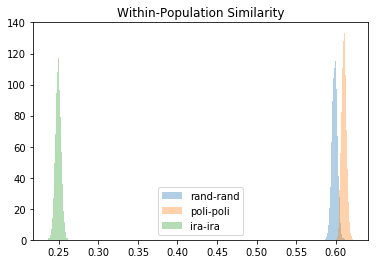

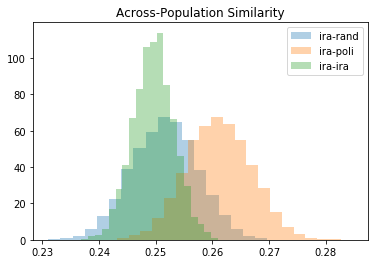

In [168]:
# Normalize by user, so we get a probability distribution of seeing specific domains
#  at the user level
twitter_user_links_mat_rand = sklearn.preprocessing.normalize(twitter_user_tld_links_df_rand[domains], norm="l2", axis=1)
twitter_user_links_mat_poli = sklearn.preprocessing.normalize(twitter_user_tld_links_df_poli[domains], norm="l2", axis=1)
twitter_user_links_mat_ira = sklearn.preprocessing.normalize(twitter_user_tld_links_df_ira[domains], norm="l2", axis=1)

# Calculate pairwise similarity among users across populations
t2t_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_rand)
t2t_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_poli, twitter_user_links_mat_poli)
t2t_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_poli)
t2t_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_rand)
t2t_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_poli)
t2t_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
t2t_rand_rand_sim_avg = (np.sum(t2t_rand_rand_sim, axis=1) - 1) / (twitter_user_links_mat_rand.shape[0] - 1)
t2t_poli_poli_sim_avg = (np.sum(t2t_poli_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_rand_poli_sim_avg = (np.sum(t2t_rand_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_ira_rand_sim_avg = np.mean(t2t_ira_rand_sim, axis=1)
t2t_ira_poli_sim_avg = np.mean(t2t_ira_poli_sim, axis=1)
t2t_ira_ira_sim_avg = np.mean(t2t_ira_ira_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(t2t_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(t2t_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(t2t_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
t2t_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_rand_sim_avg, replace=True, n_samples=t2t_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_poli_poli_sim_avg, replace=True, n_samples=t2t_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
t2t_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_rand_sim_avg, replace=True, n_samples=t2t_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_poli_sim_avg, replace=True, n_samples=t2t_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [169]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(t2t_rand_rand_sim_avg_bootstrap, t2t_poli_poli_sim_avg_bootstrap, t2t_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(t2t_poli_poli_sim_avg_bootstrap, t2t_ira_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between within-Poli and within-IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(t2t_ira_rand_sim_avg_bootstrap, t2t_ira_poli_sim_avg_bootstrap, axis=0, equal_var=True)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 18557821.990000468
p-value for Welch's t-Test between within-Poli and within-IRA: 0.0 5380.361509265212
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -83.59952359025844


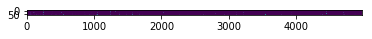

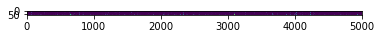

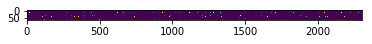

In [170]:
plt.imshow(twitter_user_links_mat_rand.T)
plt.show()
plt.imshow(twitter_user_links_mat_poli.T)
plt.show()
plt.imshow(twitter_user_links_mat_ira.T)
plt.show()

In [171]:
for label, mat in [
    ("Random", twitter_user_links_mat_rand), 
    ("Political", twitter_user_links_mat_poli), 
    ("IRA", twitter_user_links_mat_ira)]:
    print(label)
    for tld, prop in sorted(zip(domains, np.mean(mat, axis=0)), key=lambda x: x[1], reverse=True)[:10]:
        print("\t", tld, prop)

Random
	 twitter.com 0.7451584028841859
	 instagram.com 0.1526034711749727
	 youtube.com 0.1161133352846959
	 facebook.com 0.06675867237918622
	 twimg.com 0.02482474834092298
	 soundcloud.com 0.017843243027230806
	 nytimes.com 0.014497325955625359
	 wordpress.com 0.01004399209172506
	 espn.com 0.009894570818922274
	 google.com 0.008884247293663217
Political
	 twitter.com 0.7456776302928314
	 instagram.com 0.1412616725002787
	 youtube.com 0.13220154409648943
	 facebook.com 0.10269607707949237
	 nytimes.com 0.04503940497514393
	 washingtonpost.com 0.02811865677934167
	 cnn.com 0.02217463623131271
	 foxnews.com 0.021416091809950882
	 huffingtonpost.com 0.018199767649672363
	 wordpress.com 0.018128315684783007
IRA
	 youtube.com 0.41350362113186856
	 twitter.com 0.25067166824100123
	 instagram.com 0.0784595624137302
	 vimeo.com 0.048065841627619586
	 cnn.com 0.042483311310106894
	 facebook.com 0.04115977752131104
	 telegraph.co.uk 0.04025465936490333
	 nytimes.com 0.01571106909843012
	 wiki

In [172]:
reddit_user_tld_links_df_rand = links_df_to_shares(reddit_links_df_rand, domains, "user_name")
reddit_user_tld_links_df_poli = links_df_to_shares(reddit_links_df_poli, domains, "user_name")
reddit_user_tld_links_df_ira = links_df_to_shares(reddit_links_df_ira, domains, "user_name")


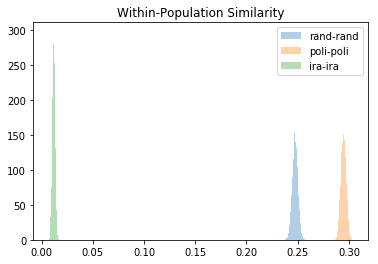

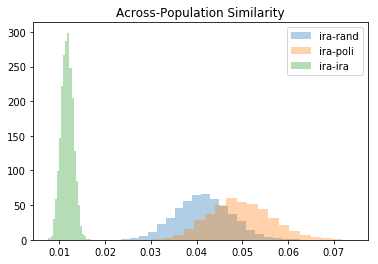

In [173]:
# Normalize by user, so we get a probability distribution of seeing specific domains
#  at the user level
reddit_user_links_mat_rand = sklearn.preprocessing.normalize(reddit_user_tld_links_df_rand[domains], norm="l2", axis=1)
reddit_user_links_mat_poli = sklearn.preprocessing.normalize(reddit_user_tld_links_df_poli[domains], norm="l2", axis=1)
reddit_user_links_mat_ira = sklearn.preprocessing.normalize(reddit_user_tld_links_df_ira[domains], norm="l2", axis=1)

# Calculate pairwise similarity among users across populations
r2r_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_rand)
r2r_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, reddit_user_links_mat_poli)
r2r_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_poli)
r2r_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_rand)
r2r_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_poli)
r2r_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
r2r_rand_rand_sim_avg = (np.sum(r2r_rand_rand_sim, axis=1) - 1) / (reddit_user_links_mat_rand.shape[0] - 1)
r2r_poli_poli_sim_avg = (np.sum(r2r_poli_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_rand_poli_sim_avg = (np.sum(r2r_rand_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_ira_rand_sim_avg = np.mean(r2r_ira_rand_sim, axis=1)
r2r_ira_poli_sim_avg = np.mean(r2r_ira_poli_sim, axis=1)
r2r_ira_ira_sim_avg = np.mean(r2r_ira_ira_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(r2r_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(r2r_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(r2r_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
r2r_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_rand_sim_avg, replace=True, n_samples=r2r_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_poli_poli_sim_avg, replace=True, n_samples=r2r_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
r2r_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_rand_sim_avg, replace=True, n_samples=r2r_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_poli_sim_avg, replace=True, n_samples=r2r_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [174]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(r2r_rand_rand_sim_avg_bootstrap, r2r_poli_poli_sim_avg_bootstrap, r2r_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2r_poli_poli_sim_avg_bootstrap, r2r_ira_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between within-Poli and within-IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2r_ira_rand_sim_avg_bootstrap, r2r_ira_poli_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 21571315.96164525
p-value for Welch's t-Test between within-Poli and within-IRA: 0.0 6888.739697516845
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -62.66143214038171


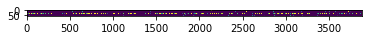

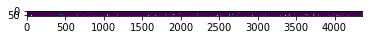

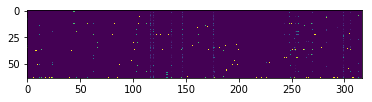

In [175]:
plt.imshow(reddit_user_links_mat_rand.T)
plt.show()
plt.imshow(reddit_user_links_mat_poli.T)
plt.show()
plt.imshow(reddit_user_links_mat_ira.T)
plt.show()

In [176]:
for label, mat in [
    ("Random", reddit_user_links_mat_rand), 
    ("Political", reddit_user_links_mat_poli), 
    ("IRA", reddit_user_links_mat_ira)]:
    print(label)
    for tld, prop in sorted(zip(domains, np.mean(mat, axis=0)), key=lambda x: x[1], reverse=True)[:10]:
        print("\t", tld, prop)

Random
	 reddit.com 0.35386685530781004
	 youtube.com 0.34449760373763744
	 twitter.com 0.0452243414208616
	 soundcloud.com 0.017079724717394912
	 google.com 0.01667595862277275
	 tumblr.com 0.014059190449714348
	 facebook.com 0.013703521464228093
	 wikipedia.org 0.012995837297543382
	 instagram.com 0.012202336985633467
	 amazon.com 0.007879639432879542
Political
	 youtube.com 0.398135811619767
	 reddit.com 0.3469190129352032
	 twitter.com 0.0884050120734825
	 washingtonpost.com 0.03936059989553357
	 nytimes.com 0.035584928305877374
	 cnn.com 0.028661961205583193
	 wikipedia.org 0.02258645882962459
	 facebook.com 0.020090461032329154
	 theguardian.com 0.01832986435026372
	 google.com 0.01786718641590284
IRA
	 youtube.com 0.07970451417461576
	 reddit.com 0.03500971282319599
	 huffingtonpost.com 0.03134501906762725
	 cnn.com 0.030575572197328562
	 nytimes.com 0.018728422373687256
	 nbcnews.com 0.016126986400284427
	 twitter.com 0.015900342393454465
	 theguardian.com 0.015221049906139825


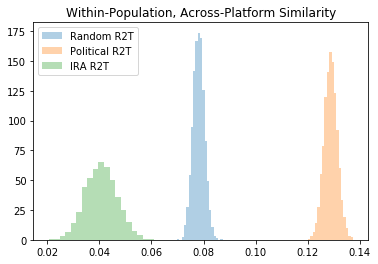

In [177]:
# Calculate pairwise similarity among users across platforms
r2t_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, twitter_user_links_mat_rand)
r2t_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, twitter_user_links_mat_poli)
r2t_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, twitter_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
r2t_rand_sim_avg = np.mean(r2t_rand_sim, axis=1)
r2t_poli_sim_avg = np.mean(r2t_poli_sim, axis=1)
r2t_ira_sim_avg = np.mean(r2t_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
r2t_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2t_rand_sim_avg, replace=True, n_samples=r2t_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2t_poli_sim_avg, replace=True, n_samples=r2t_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2t_ira_sim_avg, replace=True, n_samples=r2t_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2t_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(r2t_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()


In [178]:
# Test whether the across-platform similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(r2t_rand_sim_avg_bootstrap, r2t_poli_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2t_rand_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between Random and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2t_poli_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 612229.1525680709
p-value for Welch's t-Test between Random and IRA: 0.0 411.31697370956715
p-value for Welch's t-Test between Poli and IRA: 0.0 949.1549434117296


# YouTube Channel Distributions

We've checked the differences in top-level domain sharing, but we know YouTube was very popular as well. Now, we turn to the distributions of YouTube channels.

In [64]:
twitter_yt_df_rand = twitter_links_df_rand[twitter_links_df_rand.tld == "youtube.com"].copy()
twitter_yt_df_poli = twitter_links_df_poli[twitter_links_df_poli.tld == "youtube.com"].copy()
twitter_yt_df_ira = twitter_links_df_ira[twitter_links_df_ira.tld == "youtube.com"].copy()

twitter_yt_df_rand["video_id"] = twitter_yt_df_rand.link.apply(strip_video_id_from_url)
twitter_yt_df_poli["video_id"] = twitter_yt_df_poli.link.apply(strip_video_id_from_url)
twitter_yt_df_ira["video_id"] = twitter_yt_df_ira.link.apply(strip_video_id_from_url)

twitter_yt_df_rand = twitter_yt_df_rand.dropna(subset=["video_id"])
twitter_yt_df_poli = twitter_yt_df_poli.dropna(subset=["video_id"])
twitter_yt_df_ira = twitter_yt_df_ira.dropna(subset=["video_id"])


In [73]:
twitter_video_ids = set(twitter_yt_df_rand["video_id"]).union(set(twitter_yt_df_poli["video_id"])).union(set(twitter_yt_df_ira["video_id"]))
print("Unique YT Videos:", len(twitter_video_ids))

with open("twitter_all_video_ids.csv", "w") as out_file:
    out_file.write("video_id\n")
    for video_id in twitter_video_ids:
        if ( len(video_id.strip()) == 0 ):
            continue
        out_file.write("%s\n" % video_id)

Unique YT Videos: 154835


In [65]:
reddit_yt_df_rand = reddit_links_df_rand[reddit_links_df_rand.tld == "youtube.com"].copy()
reddit_yt_df_poli = reddit_links_df_poli[reddit_links_df_poli.tld == "youtube.com"].copy()
reddit_yt_df_ira = reddit_links_df_ira[reddit_links_df_ira.tld == "youtube.com"].copy()

reddit_yt_df_rand["video_id"] = reddit_yt_df_rand.link.apply(strip_video_id_from_url)
reddit_yt_df_poli["video_id"] = reddit_yt_df_poli.link.apply(strip_video_id_from_url)
reddit_yt_df_ira["video_id"] = reddit_yt_df_ira.link.apply(strip_video_id_from_url)

reddit_yt_df_rand = reddit_yt_df_rand.dropna(subset=["video_id"])
reddit_yt_df_poli = reddit_yt_df_poli.dropna(subset=["video_id"])
reddit_yt_df_ira = reddit_yt_df_ira.dropna(subset=["video_id"])


In [75]:
reddit_video_ids = set(reddit_yt_df_rand["video_id"]).union(set(reddit_yt_df_poli["video_id"])).union(set(reddit_yt_df_ira["video_id"]))
print("Unique YT Videos:", len(reddit_video_ids))

with open("reddit_all_video_ids.csv", "w") as out_file:
    out_file.write("video_id\n")
    for video_id in reddit_video_ids:
        if ( len(video_id.strip()) == 0 ):
            continue
        video_id = video_id.replace("%", "")
        out_file.write("%s\n" % video_id)

Unique YT Videos: 50348


In [71]:
all_video_ids = reddit_video_ids.union(twitter_video_ids)
print("Merged YT Videos:", len(all_video_ids))

with open("twitter+reddit_all_video_ids.csv", "w") as out_file:
    out_file.write("video_id\n")
    for video_id in all_video_ids:
        if ( len(video_id.strip()) == 0 ):
            continue
        out_file.write("%s\n" % video_id)

Merged YT Videos: 202324


In [148]:

twitter_yt_meta_df = pd.read_csv("twitter_video_metadata.csv")
twitter_yt_vid2chan_map = {row["video_id"]:row["channel_id"] for idx, row in twitter_yt_meta_df.iterrows()}

twitter_yt_df_rand["channel_id"] = twitter_yt_df_rand["video_id"].apply(twitter_yt_vid2chan_map.get)
twitter_yt_df_poli["channel_id"] = twitter_yt_df_poli["video_id"].apply(twitter_yt_vid2chan_map.get)
twitter_yt_df_ira["channel_id"] = twitter_yt_df_ira["video_id"].apply(twitter_yt_vid2chan_map.get)

twitter_top_yt_chans_rand = get_top_channels(twitter_yt_df_rand, user_id_field="user_id", top_n=top_n_channels)
twitter_top_yt_chans_poli = get_top_channels(twitter_yt_df_poli, user_id_field="user_id", top_n=top_n_channels)
twitter_top_yt_chans_ira = get_top_channels(twitter_yt_df_ira, user_id_field="user_id", top_n=top_n_channels)

twitter_merged_yt_chans = set(twitter_top_yt_chans_rand)\
    .intersection(twitter_top_yt_chans_poli)
#     .intersection(twitter_top_yt_chans_ira)
print("Merged Top Channels:", len(twitter_merged_yt_chans))



Merged Top Channels: 205


In [149]:

reddit_yt_meta_df = pd.read_csv("reddit_all_video_metadata.csv")
reddit_yt_vid2chan_map = {row["video_id"]:row["channel_id"] for idx, row in reddit_yt_meta_df.iterrows()}

reddit_yt_df_rand["channel_id"] = reddit_yt_df_rand["video_id"].apply(reddit_yt_vid2chan_map.get)
reddit_yt_df_poli["channel_id"] = reddit_yt_df_poli["video_id"].apply(reddit_yt_vid2chan_map.get)
reddit_yt_df_ira["channel_id"] = reddit_yt_df_ira["video_id"].apply(reddit_yt_vid2chan_map.get)

reddit_top_yt_chans_rand = get_top_channels(reddit_yt_df_rand, user_id_field="user_name", top_n=top_n_channels)
reddit_top_yt_chans_poli = get_top_channels(reddit_yt_df_poli, user_id_field="user_name", top_n=top_n_channels)
reddit_top_yt_chans_ira = get_top_channels(reddit_yt_df_ira, user_id_field="user_name", top_n=top_n_channels)

reddit_merged_yt_chans = set(reddit_top_yt_chans_rand)\
    .intersection(reddit_top_yt_chans_poli)
#     .intersection(reddit_top_yt_chans_ira)
print("Merged Top Channels:", len(reddit_merged_yt_chans))




Merged Top Channels: 122


In [150]:
set(twitter_top_yt_chans_ira).intersection(set(reddit_top_yt_chans_ira))

{'UC16niRr50-MSBwiO3YDb3RA',
 'UC1yBKRuGpC1tSM73A0ZjYjQ',
 'UC6ZFN9Tx6xh-skXCuRHCDpQ',
 'UCIveFvW-ARp_B_RckhweNJw',
 'UCV3Nm3T-XAgVhKH9jT0ViRg',
 'UCXMYxKMh3prxnM_4kYZuB3g',
 'UCby-X956H1uhnTMA0bqzkFg',
 'UCczrL-2b-gYK3l4yDld4XlQ',
 'UCdxi8d8qRsRyUi2ERYjYb-w',
 'UCittVh8imKanO_5KohzDbpg',
 'UCpwvZwUam-URkxB7g4USKpg',
 'UCupvZG-5ko_eiXAupbDfxWw',
 'UCzUV5283-l5c0oKRtyenj6Q',
 'UCzuqE7-t13O4NIDYJfakrhw'}

In [151]:
all_top_channels = reddit_merged_yt_chans.intersection(twitter_merged_yt_chans)
print("Cross-Platform Top Channels:", len(all_top_channels))

Cross-Platform Top Channels: 65


In [152]:
channels = sorted(all_top_channels)

In [153]:
twitter_user_chans_df_rand = channels_df_to_shares(twitter_yt_df_rand, channels, "user_id")
twitter_user_chans_df_poli = channels_df_to_shares(twitter_yt_df_poli, channels, "user_id")
twitter_user_chans_df_ira = channels_df_to_shares(twitter_yt_df_ira, channels, "user_id")


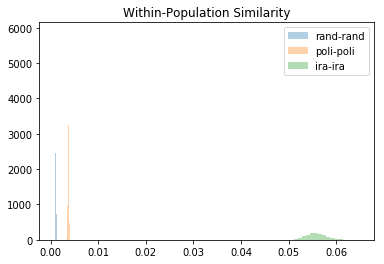

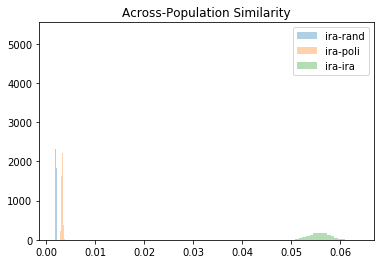

In [154]:
# Normalize by user, so we get a probability distribution of seeing specific domains
#  at the user level
twitter_user_links_mat_rand = sklearn.preprocessing.normalize(twitter_user_chans_df_rand[channels], norm="l2", axis=1)
twitter_user_links_mat_poli = sklearn.preprocessing.normalize(twitter_user_chans_df_poli[channels], norm="l2", axis=1)
twitter_user_links_mat_ira = sklearn.preprocessing.normalize(twitter_user_chans_df_ira[channels], norm="l2", axis=1)

# Calculate pairwise similarity among users across populations
t2t_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_rand)
t2t_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_poli, twitter_user_links_mat_poli)
t2t_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_poli)
t2t_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_rand)
t2t_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_poli)
t2t_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
t2t_rand_rand_sim_avg = (np.sum(t2t_rand_rand_sim, axis=1) - 1) / (twitter_user_links_mat_rand.shape[0] - 1)
t2t_poli_poli_sim_avg = (np.sum(t2t_poli_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_rand_poli_sim_avg = (np.sum(t2t_rand_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_ira_rand_sim_avg = np.mean(t2t_ira_rand_sim, axis=1)
t2t_ira_poli_sim_avg = np.mean(t2t_ira_poli_sim, axis=1)
t2t_ira_ira_sim_avg = np.mean(t2t_ira_ira_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(t2t_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(t2t_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(t2t_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
t2t_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_rand_sim_avg, replace=True, n_samples=t2t_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_poli_poli_sim_avg, replace=True, n_samples=t2t_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
t2t_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_rand_sim_avg, replace=True, n_samples=t2t_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_poli_sim_avg, replace=True, n_samples=t2t_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [155]:
reddit_user_chans_df_rand = channels_df_to_shares(reddit_yt_df_rand, channels, "user_name")
reddit_user_chans_df_poli = channels_df_to_shares(reddit_yt_df_poli, channels, "user_name")
reddit_user_chans_df_ira = channels_df_to_shares(reddit_yt_df_ira, channels, "user_name")


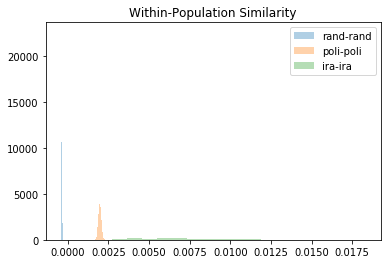

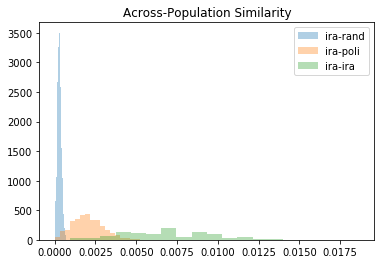

In [156]:
# Normalize by user, so we get a probability distribution of seeing specific domains
#  at the user level
reddit_user_links_mat_rand = sklearn.preprocessing.normalize(reddit_user_chans_df_rand[channels], norm="l2", axis=1)
reddit_user_links_mat_poli = sklearn.preprocessing.normalize(reddit_user_chans_df_poli[channels], norm="l2", axis=1)
reddit_user_links_mat_ira = sklearn.preprocessing.normalize(reddit_user_chans_df_ira[channels], norm="l2", axis=1)

# Calculate pairwise similarity among users across populations
r2r_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_rand)
r2r_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, reddit_user_links_mat_poli)
r2r_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_poli)
r2r_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_rand)
r2r_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_poli)
r2r_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
r2r_rand_rand_sim_avg = (np.sum(r2r_rand_rand_sim, axis=1) - 1) / (reddit_user_links_mat_rand.shape[0] - 1)
r2r_poli_poli_sim_avg = (np.sum(r2r_poli_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_rand_poli_sim_avg = (np.sum(r2r_rand_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_ira_rand_sim_avg = np.mean(r2r_ira_rand_sim, axis=1)
r2r_ira_poli_sim_avg = np.mean(r2r_ira_poli_sim, axis=1)
r2r_ira_ira_sim_avg = np.mean(r2r_ira_ira_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(r2r_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(r2r_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(r2r_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
r2r_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_rand_sim_avg, replace=True, n_samples=r2r_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_poli_poli_sim_avg, replace=True, n_samples=r2r_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
r2r_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_rand_sim_avg, replace=True, n_samples=r2r_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_poli_sim_avg, replace=True, n_samples=r2r_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

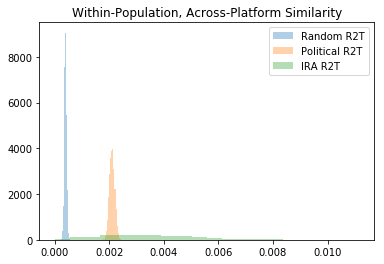

In [157]:
# Calculate pairwise similarity among users across platforms
r2t_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, twitter_user_links_mat_rand)
r2t_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, twitter_user_links_mat_poli)
r2t_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, twitter_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
r2t_rand_sim_avg = np.mean(r2t_rand_sim, axis=1)
r2t_poli_sim_avg = np.mean(r2t_poli_sim, axis=1)
r2t_ira_sim_avg = np.mean(r2t_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
r2t_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2t_rand_sim_avg, replace=True, n_samples=r2t_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2t_poli_sim_avg, replace=True, n_samples=r2t_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2t_ira_sim_avg, replace=True, n_samples=r2t_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2t_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(r2t_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()

